In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
#import spotpy
from matplotlib.offsetbox import AnchoredText
#from scipy import stats, signal, optimize
#import hydroeval as he
sns.set(style='whitegrid', palette='deep')

In [2]:
from sdm import SDM

#import statsmodels.api as sm
#import altair as alt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [3]:
#load climate data
#climate = xr.load_dataset('input/RCM_krummh_new.nc')
climate = xr.load_dataset('C:/Users/Jonas Lenz/Desktop/RUINS/data/hydropaper/input/cordex_krummh22.nc')

weather = xr.load_dataset('data/weather.nc')


In [4]:
#keys = list(climate.keys())
keys = [s for s in list(climate.keys()) if 'HadGEM2-ES' not in s] #remove all entries of HadGEM2-ES (6 entries) - as done in RUINSapp.py

In [5]:
# filter keys, which are present in separate RCPs
kes_bool = pd.Series(keys).str.contains("rcp26").tolist()
filtered_26 = sort(np.array(keys)[np.array(kes_bool)])

kes_bool = pd.Series(keys).str.contains("rcp45").tolist()
filtered_45 = sort(np.array(keys)[np.array(kes_bool)])

kes_bool = pd.Series(keys).str.contains("rcp85").tolist()
filtered_85 = sort(np.array(keys)[np.array(kes_bool)])


In [6]:
# select only models/initial + boundary conditions which are present in all RCPs
included_all = []

for x in filtered_26:
    model = x.replace(".rcp26","")
    included_45 = any(pd.Series(filtered_45).str.contains(model))
    included_85 = any(pd.Series(filtered_45).str.contains(model))
    if all([included_45, included_85]):
        included_all = np.append(included_all, model)
#print(model)
print(included_all.shape)
included_all

(16,)


array(['CLMcom.EC-EARTH.CCLM4-8-17.r12i1p1',
       'DMI.EC-EARTH.HIRHAM5.r3i1p1',
       'DWD.CERFACS-CNRM-CM5.EPISODES2018.r1i1p1',
       'DWD.CanESM2.EPISODES2018.r1i1p1',
       'DWD.CanESM2.EPISODES2018.r3i1p1',
       'DWD.CanESM2.EPISODES2018.r4i1p1',
       'DWD.CanESM2.EPISODES2018.r5i1p1',
       'DWD.M-MPI-ESM-LR.EPISODES2018.r1i1p1',
       'DWD.M-MPI-ESM-LR.EPISODES2018.r2i1p1',
       'DWD.M-MPI-ESM-LR.EPISODES2018.r3i1p1',
       'DWD.NorESM1-M.EPISODES2018.r1i1p1',
       'GERICS.NorESM1-M.REMO2015.r1i1p1',
       'KNMI.CERFACS-CNRM-CM5.RACMO22E.r1i1p1',
       'KNMI.EC-EARTH.RACMO22E.r12i1p1',
       'MPI-CSC.M-MPI-ESM-LR.REMO2009.r1i1p1',
       'MPI-CSC.M-MPI-ESM-LR.REMO2009.r2i1p1'], dtype='<U40')

In [7]:
# exclude those keys, which have 0- rainfall years in target periods
for rcp in ['.rcp26','.rcp45','.rcp85']:
    missing_P = []
    for z in included_all:
        abc = climate[z+rcp].to_dataframe().reset_index(level=[1]).pivot(columns='vars',values=z+rcp)['Prec'].resample('1y').sum()[1:]
        #if (any(abc['2010':'2020'] <=0) or any(abc['2050':'2060'] <=0) or any(abc['2090':'2100'] <=0)):
        if (any(abc['2010':'2020'] <=0) or any(abc['2090':'2100'] <=0)):
            missing_P = np.append(missing_P, False)
        else:
            missing_P = np.append(missing_P, True)
    included_all = np.array(included_all)[np.array(missing_P, dtype = bool)]
        
print(included_all.shape)
included_all

(9,)


array(['CLMcom.EC-EARTH.CCLM4-8-17.r12i1p1',
       'DWD.CERFACS-CNRM-CM5.EPISODES2018.r1i1p1',
       'DWD.CanESM2.EPISODES2018.r4i1p1',
       'DWD.M-MPI-ESM-LR.EPISODES2018.r1i1p1',
       'DWD.M-MPI-ESM-LR.EPISODES2018.r2i1p1',
       'DWD.NorESM1-M.EPISODES2018.r1i1p1',
       'GERICS.NorESM1-M.REMO2015.r1i1p1',
       'KNMI.CERFACS-CNRM-CM5.RACMO22E.r1i1p1',
       'KNMI.EC-EARTH.RACMO22E.r12i1p1'], dtype='<U40')

# BIAS correction

In [8]:
def applySDM(wdata, data, meth='rel', cdf_threshold=0.9999999, lower_limit=0.1):
    '''apply structured distribution mapping to climate data and return unbiased version of dataset'''
    from sdm import SDM
    data_ub = data.copy()

    for k in data_ub.columns:
        data_col = data_ub[k].dropna()
        overlapx = pd.concat(
            [wdata.loc[data_col.index[0]:wdata.index[-1]], data_col.loc[data_col.index[0]:wdata.index[-1]]], axis=1)
        overlapx.columns = ['obs', 'cm']
        overlapx = overlapx.dropna()
        try:
            data_ub[k] = SDM(overlapx.obs, overlapx.cm, data_col, meth, cdf_threshold, lower_limit)
        except:
            data_ub[k] = data_ub[k] * np.nan

    data_ub[data_ub == 0.0000000] = np.nan
    data_ub = data_ub.loc[data_ub.index[0]:pd.to_datetime('2099-12-31 23:59:59')]

    return data_ub


In [26]:
z = included_all[8]
rcp = '.rcp85'

vari = 'Prec'
meth = 'rel'

#vari = 'T'
#meth = 'abs'

vari = 'Rs'
meth = 'abs'

In [27]:
climate.vars

<xarray.DataArray 'vars' (vars: 14)>
array(['T', 'Tmax', 'Tmin', 'Prec', 'Rs', 'RH', 'u2', 'vabar', 'aP', 'EToPM',
       'EToPM1', 'EToHG', 'EToSJ', 'EToPT'], dtype=object)
Coordinates:
  * vars     (vars) object 'T' 'Tmax' 'Tmin' 'Prec' ... 'EToHG' 'EToSJ' 'EToPT'

In [28]:
weather.vars

<xarray.DataArray 'vars' (vars: 16)>
array(['T', 'Tmin', 'Tmax', 'Prec', 'Rad', 'Rs', 'RH', 'u2', 'u2mx', 'vap',
       'aP', 'EToPM', 'EToHG', 'EToSJ', 'EToPM2', 'EToPT'], dtype=object)
Coordinates:
  * vars     (vars) object 'T' 'Tmin' 'Tmax' 'Prec' ... 'EToSJ' 'EToPM2' 'EToPT'

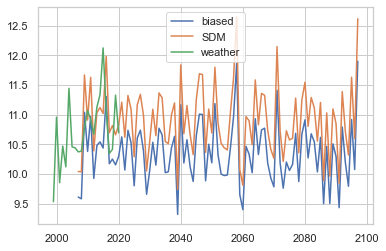

In [29]:

#w1 = weather['Emden'].sel(vars=vari).to_dataframe().dropna()
w1 = weather['Norderney'].sel(vars=vari).to_dataframe()['1998':'2019']
w1.columns = ['bla', vari]

c1 = climate[z+rcp].sel(vars=vari).to_dataframe()
#c1 = c1[c1.columns[c1.columns != 'vars']]
c1 = c1[c1.columns[c1.columns != 'vars']]['2006':]

c2 = applySDM(w1[vari], c1, meth=meth)

if vari == 'Prec':
    plot(c1.resample('1y').sum(), label=('biased'))
    plot(c2.resample('1y').sum(), label ='SDM')
    plot(w1[vari].resample('1y').sum(), label ='weather')
else:
    plot(c1.resample('1y').mean(), label=('biased'))
    plot(c2.resample('1y').mean(), label ='SDM')
    plot(w1[vari].resample('1y').mean(), label ='weather')
legend()